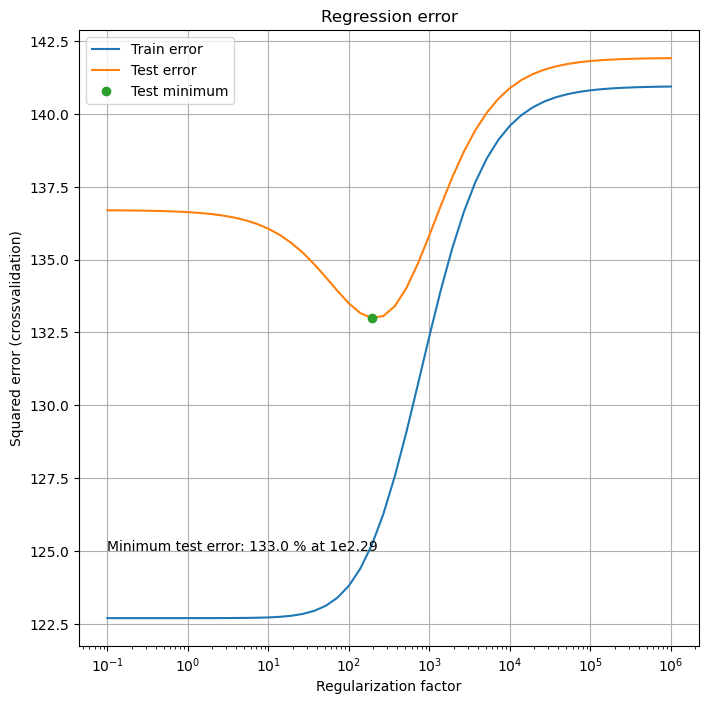

Regularized linear regression:
- Training error: 125.21409099518515
- Test error:     132.99691122927226
- R^2 train:     0.9111683792709713
- R^2 test:     0.9025322145398369

Weights in last fold:
         Offset           60.92
        anaemia             0.5
creatinine_phosphokinase           -0.62
       diabetes           -0.31
ejection_fraction             0.8
high_blood_pressure             0.6
      platelets           -0.21
serum_creatinine            0.67
   serum_sodium            -0.4
            sex            0.57
        smoking            0.02
           time           -0.89
    DEATH_EVENT            1.64


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import rlr_validate
import pandas as pd

filename = 'heart_failure_clinical_records_dataset.csv'
df = pd.read_csv(filename)
y = df['age']
X = df.drop(['age'], axis = 1)
attributeNames = list(X.keys())
X = X.to_numpy()
y = y.to_numpy()

classNames = "DEATH_EVENT"
N, M = X.shape
C = 2
# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(K, shuffle=True)
#CV = model_selection.KFold(K, shuffle=False)

# Values of lambda
lambdas = np.logspace(-1, 6, 50)

# Initialize variables
#T = len(lambdas)
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_rlr = np.empty((K,1))
Error_test_rlr = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))
train_error = np.empty((K,len(lambdas)))
test_error = np.empty((K,len(lambdas)))
w = np.empty((M,K, len(lambdas)))
mu = np.empty((K, M-1))
sigma = np.empty((K, M-1))
w_noreg = np.empty((M,K))

k=0
for train_index, test_index in CV.split(X,y):
    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]

    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu[k, :] = np.mean(X_train[:, 1:], 0)
    sigma[k, :] = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu[k, :] ) / sigma[k, :] 
    X_test[:, 1:] = (X_test[:, 1:] - mu[k, :] ) / sigma[k, :] 
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Compute mean squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum(axis=0)/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]

    for l in range(0,len(lambdas)):
        # Compute parameters for current value of lambda and current CV fold
        # note: "linalg.lstsq(a,b)" is substitue for Matlab's left division operator "\"
        lambdaI = lambdas[l] * np.eye(M)
        lambdaI[0,0] = 0 # remove bias regularization
        w[:,k,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
        # Evaluate training and test performance
        train_error[k,l] = np.power(y_train-X_train @ w[:,k,l].T,2).mean(axis=0)
        test_error[k,l] = np.power(y_test-X_test @ w[:,k,l].T,2).mean(axis=0)

    opt_val_err = np.min(np.mean(test_error,axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error,axis=0))]
    train_err_vs_lambda = np.mean(train_error,axis=0)
    test_err_vs_lambda = np.mean(test_error,axis=0)
    mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))

    train_err_opt_lambda = train_error[:, np.argmin(np.mean(test_error,axis=0))]
    test_err_opt_lambda = test_error[:, np.argmin(np.mean(test_error,axis=0))]
    w_opt_lambda = w[:, :, np.argmin(np.mean(test_error,axis=0))]
    
    # Display the results for the last cross-validation fold
    if k == K-1:
        plt.figure(figsize=(8,8))
        plt.semilogx(lambdas, train_err_vs_lambda)
        plt.semilogx(lambdas, test_err_vs_lambda)
        plt.semilogx(opt_lambda, opt_val_err, 'o')
        plt.text(1e-1, 125, "Minimum test error: " + str(np.round(opt_val_err,2)) + ' % at 1e' + str(np.round(np.log10(opt_lambda),2)))
        plt.xlabel('Regularization factor')
        plt.ylabel('Squared error (crossvalidation)')
        plt.title('Regression error')
        plt.legend(['Train error','Test error', 'Test minimum'], loc="best")
        plt.grid()
    
    # To inspect the used indices, use these print statements
    #print('Cross validation fold {0}/{1}:'.format(k+1,K))
    #print('Train indices: {0}'.format(train_index))
    #print('Test indices: {0}\n'.format(test_index))

    k+=1

plt.show()
# Display results
print('Regularized linear regression:')
print('- Training error: {0}'.format(train_err_opt_lambda.mean()))
print('- Test error:     {0}'.format(test_err_opt_lambda.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-train_err_opt_lambda.mean())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}\n'.format((Error_test_nofeatures.sum()-test_err_opt_lambda.mean())/Error_test_nofeatures.sum()))

print('Weights in last fold:')
for m in range(M):
    print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_opt_lambda[m, -1],2)))
